# <center> <span style="font-family: ClearSans-Bold, sans-serif; color:#7060eb">Building interpretable boosted scorecards</span> </center>

 <span style="font-family: ClearSans, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

<div class="alert alert-block alert-info">
 <span style="font-family: ClearSans, sans-serif; color:navyblue"><b>Credit:</b> This notebook contains refactored <a href="https://github.com/rapidsai-community/showcase/tree/main/event_notebooks/GTC_2021/credit_scorecard" title="Building Credit Risk Scorecards with RAPIDS">code</a> from the talk <a href="https://www.nvidia.com/en-us/on-demand/session/gtcspring21-s31327/" title="Machine Learning in Retail Credit Risk: Algorithms, Infrastructure, and Alternative Data — Past, Present, and Future">Machine Learning in Retail Credit Risk</a> (P. Edwards, S.Denton, Scotiabank) and Weights and Biases' "XGBoost for Interpretable Credit Models" <a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/boosting/Credit_Scorecards_with_XGBoost_and_W%26B.ipynb" title="XGBoost for Interpretable Credit Models">notebook</a> and <a href="https://wandb.ai/morgan/credit_scorecard/artifacts/dataset/vehicle_loan_defaults/v1" title="credit_scorecard">credit_scorecard W&B workspace</a></div>

In [20]:
%%capture
!pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
from matplotlib import rc, rcParams, font_manager

font_manager.fontManager.addfont('./fonts/ClearSans-Thin.ttf')

plt.rcParams['font.family'] = 'Clear Sans Thin'
plt.rcParams['figure.figsize'] = 8, 6
pd.set_option('display.max_columns', None)

font = {'family': 'Clear Sans Thin',
        'weight': 'bold',
        'size': 16}
rc('font', **font)

In [3]:
import boosted_scorecard
from get_credit_scores import get_credit_scores

### <span style="font-family: ClearSans-Bold, sans-serif; color:#7060eb">Data preprocessing</span>

In [4]:
# FICO Explainable Machine Learning Challenge dataset
data = pd.read_csv('heloc_dataset_v1.csv')
data['RiskPerformance'].replace({'Good': 0, 'Bad': 1}, inplace=True)

In [5]:
# Source: http://gnpalencia.org/optbinning/tutorials/tutorial_binning_process_FICO_update_binning.html
binning_fit_params = {
    "ExternalRiskEstimate": {"monotonic_trend": "descending"},
    "MSinceOldestTradeOpen": {"monotonic_trend": "descending"},
    "MSinceMostRecentTradeOpen": {"monotonic_trend": "descending"},
    "AverageMInFile": {"monotonic_trend": "descending"},
    "NumSatisfactoryTrades": {"monotonic_trend": "descending"},
    "NumTrades60Ever2DerogPubRec": {"monotonic_trend": "ascending"},
    "NumTrades90Ever2DerogPubRec": {"monotonic_trend": "ascending"},
    "PercentTradesNeverDelq": {"monotonic_trend": "descending"},
    "MSinceMostRecentDelq": {"monotonic_trend": "descending"},
    "NumTradesOpeninLast12M": {"monotonic_trend": "ascending"},
    "MSinceMostRecentInqexcl7days": {"monotonic_trend": "descending"},
    "NumInqLast6M": {"monotonic_trend": "ascending"},
    "NumInqLast6Mexcl7days": {"monotonic_trend": "ascending"},
    "NetFractionRevolvingBurden": {"monotonic_trend": "ascending"},
    "NetFractionInstallBurden": {"monotonic_trend": "ascending"},
    "NumBank2NatlTradesWHighUtilization": {"monotonic_trend": "ascending"}
}

In [6]:
# create monotonic constraints
feature_trends = pd.DataFrame(binning_fit_params).T.reset_index()
feature_trends.replace({'descending': -1, 'ascending': 1}, inplace=True)
feature_trends.rename({'index': 'feature'}, axis=1, inplace=True)

dictionary = {'feature': [], 'value':[]}

# treat special codes in a prudent way
for feature in feature_trends['feature'].unique():
    if data[feature].isin([-9, -8, -7]).any():
        correlation = data[feature].corr(data['RiskPerformance'])
        if correlation > 0:
            replace_value = data[feature].max()
            data[feature] = np.where(data[feature].isin([-9, -8, -7]), replace_value, data[feature])
        else:
            replace_value = data[feature][data[feature].apply(lambda x: x not in [-9, -8, -7])].min()
            data[feature] = np.where(data[feature].isin([-9, -8, -7]), replace_value, data[feature])

In [7]:
feature_trends[0:5]

,feature,monotonic_trend
0,ExternalRiskEstimate,-1
1,MSinceOldestTradeOpen,-1
2,MSinceMostRecentTradeOpen,-1
3,AverageMInFile,-1
4,NumSatisfactoryTrades,-1


### <span style="font-family: ClearSans-Bold, sans-serif; color:#7060eb">Sampling</span>

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# define features and monotonic constraints
features = feature_trends['feature'].to_list()
mc = str(feature_trends['monotonic_trend'].to_list())[1:-1]

In [10]:
# features and target
X = data[features + ['RiskPerformance']].copy()
y = X.pop('RiskPerformance')

# sampling (train / test / hold-out)
ix_train_full, ix_test = train_test_split(
    X.index,
    stratify=y, 
    test_size=0.2, 
    random_state=24)

ix_train, ix_val = train_test_split(
    X.loc[ix_train_full].index, 
    stratify=y.loc[ix_train_full], 
    test_size=0.25, 
    random_state=24)

print(f"Train: {len(ix_train):,.0f}\nTest: {len(ix_test):,.0f}\nValidation: {len(ix_val):,.0f}")

Train: 6,275
Test: 2,092
Validation: 2,092


### <span style="font-family: ClearSans-Bold, sans-serif; color:#7060eb">Scoring function</span>

In [11]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [84]:
# scorer
val_metrics = ['auc', 'logloss']
base_score = y.loc[ix_train].mean().item()

# train and validation sets
eval_set = [(X.loc[ix_train], y.loc[ix_train]), 
            (X.loc[ix_test], y.loc[ix_test])]

params = {
    'base_score': base_score,
    'learning_rate': 0.2,
    'n_estimators': 45, 
    'max_depth': 1,
    'monotone_constraints': f'({mc})',
    'eval_metric': val_metrics,
    'early_stopping_rounds': 5,
    'tree_method': 'hist',
    'random_state': 24,
}

start_time = time.time()
xgb_model = XGBClassifier(**params)

xgb_model.fit(
    X.loc[ix_train], 
    y.loc[ix_train], 
    eval_set=eval_set,
    verbose=False)

execution_time = time.time() - start_time
print(f"Training time: {execution_time:.4f} seconds")

preds = xgb_model.predict_proba(X.loc[ix_val])[:, 1]
gini = roc_auc_score(y.loc[ix_val], preds)*2-1
print(f"Hold-out Gini: {gini:.2%}")

bstr = xgb_model.get_booster()
print(f"Best iteration: {bstr.best_iteration}")

Training time: 0.1512 seconds
Hold-out Gini: 51.25%
Best iteration: 44


### <span style="font-family: ClearSans-Bold, sans-serif; color:#7060eb">Boosted scorecard</span>

In [99]:
# generate a scorecard
scorecard = boosted_scorecard.generate_scorecard(bstr, base_rate=y.loc[ix_train].mean().item())
display(scorecard)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Feature,Sign,Split,Inc_Missing,XAddEvidence,Score,Points
Tree,,,,,,,
0,ExternalRiskEstimate,<,74.0,0,0.134515,0.134515,0
0,ExternalRiskEstimate,>=,74.0,1,-0.196790,-0.196790,24
1,ExternalRiskEstimate,<,71.0,0,0.134740,0.134740,0
1,ExternalRiskEstimate,>=,71.0,1,-0.134625,-0.134625,19
2,ExternalRiskEstimate,<,74.0,0,0.091876,0.091876,0
2,ExternalRiskEstimate,>=,74.0,1,-0.132428,-0.132428,16
3,ExternalRiskEstimate,<,79.0,0,0.058818,0.058818,0
3,ExternalRiskEstimate,>=,79.0,1,-0.154774,-0.154774,15
4,ExternalRiskEstimate,<,71.0,0,0.083148,0.083148,0


,Feature,Sign,Split,Inc_Missing,XAddEvidence,Score,Points
Tree,,,,,,,
0,ExternalRiskEstimate,<,74.0,0,0.134515,0.134515,0
0,ExternalRiskEstimate,>=,74.0,1,-0.196790,-0.196790,24


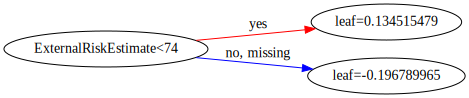

In [100]:
# show scorecard's first level
tree_i=0
display(scorecard.loc[[tree_i]])
xgb.to_graphviz(xgb_model, num_trees=tree_i, rankdir='LR')

,Feature,Sign,Split,Inc_Missing,XAddEvidence,Score,Points
Tree,,,,,,,
1,ExternalRiskEstimate,<,71.0,0,0.134740,0.134740,0
1,ExternalRiskEstimate,>=,71.0,1,-0.134625,-0.134625,19


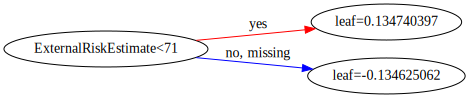

In [101]:
# show scorecard's second level
tree_i=1
display(scorecard.loc[[tree_i]])
xgb.to_graphviz(xgb_model, num_trees=tree_i, rankdir='LR')

In [88]:
# combine test and validation sets
ix_val_full = ix_val.append(ix_test)

# get credit scores
start_time = time.time()

val_scores = get_credit_scores(df=X.loc[ix_val_full], 
                               features=X.columns.to_list(),
                               scorecard=scorecard)
# Calculate the execution time
execution_time = time.time() - start_time

print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 0.1052 seconds


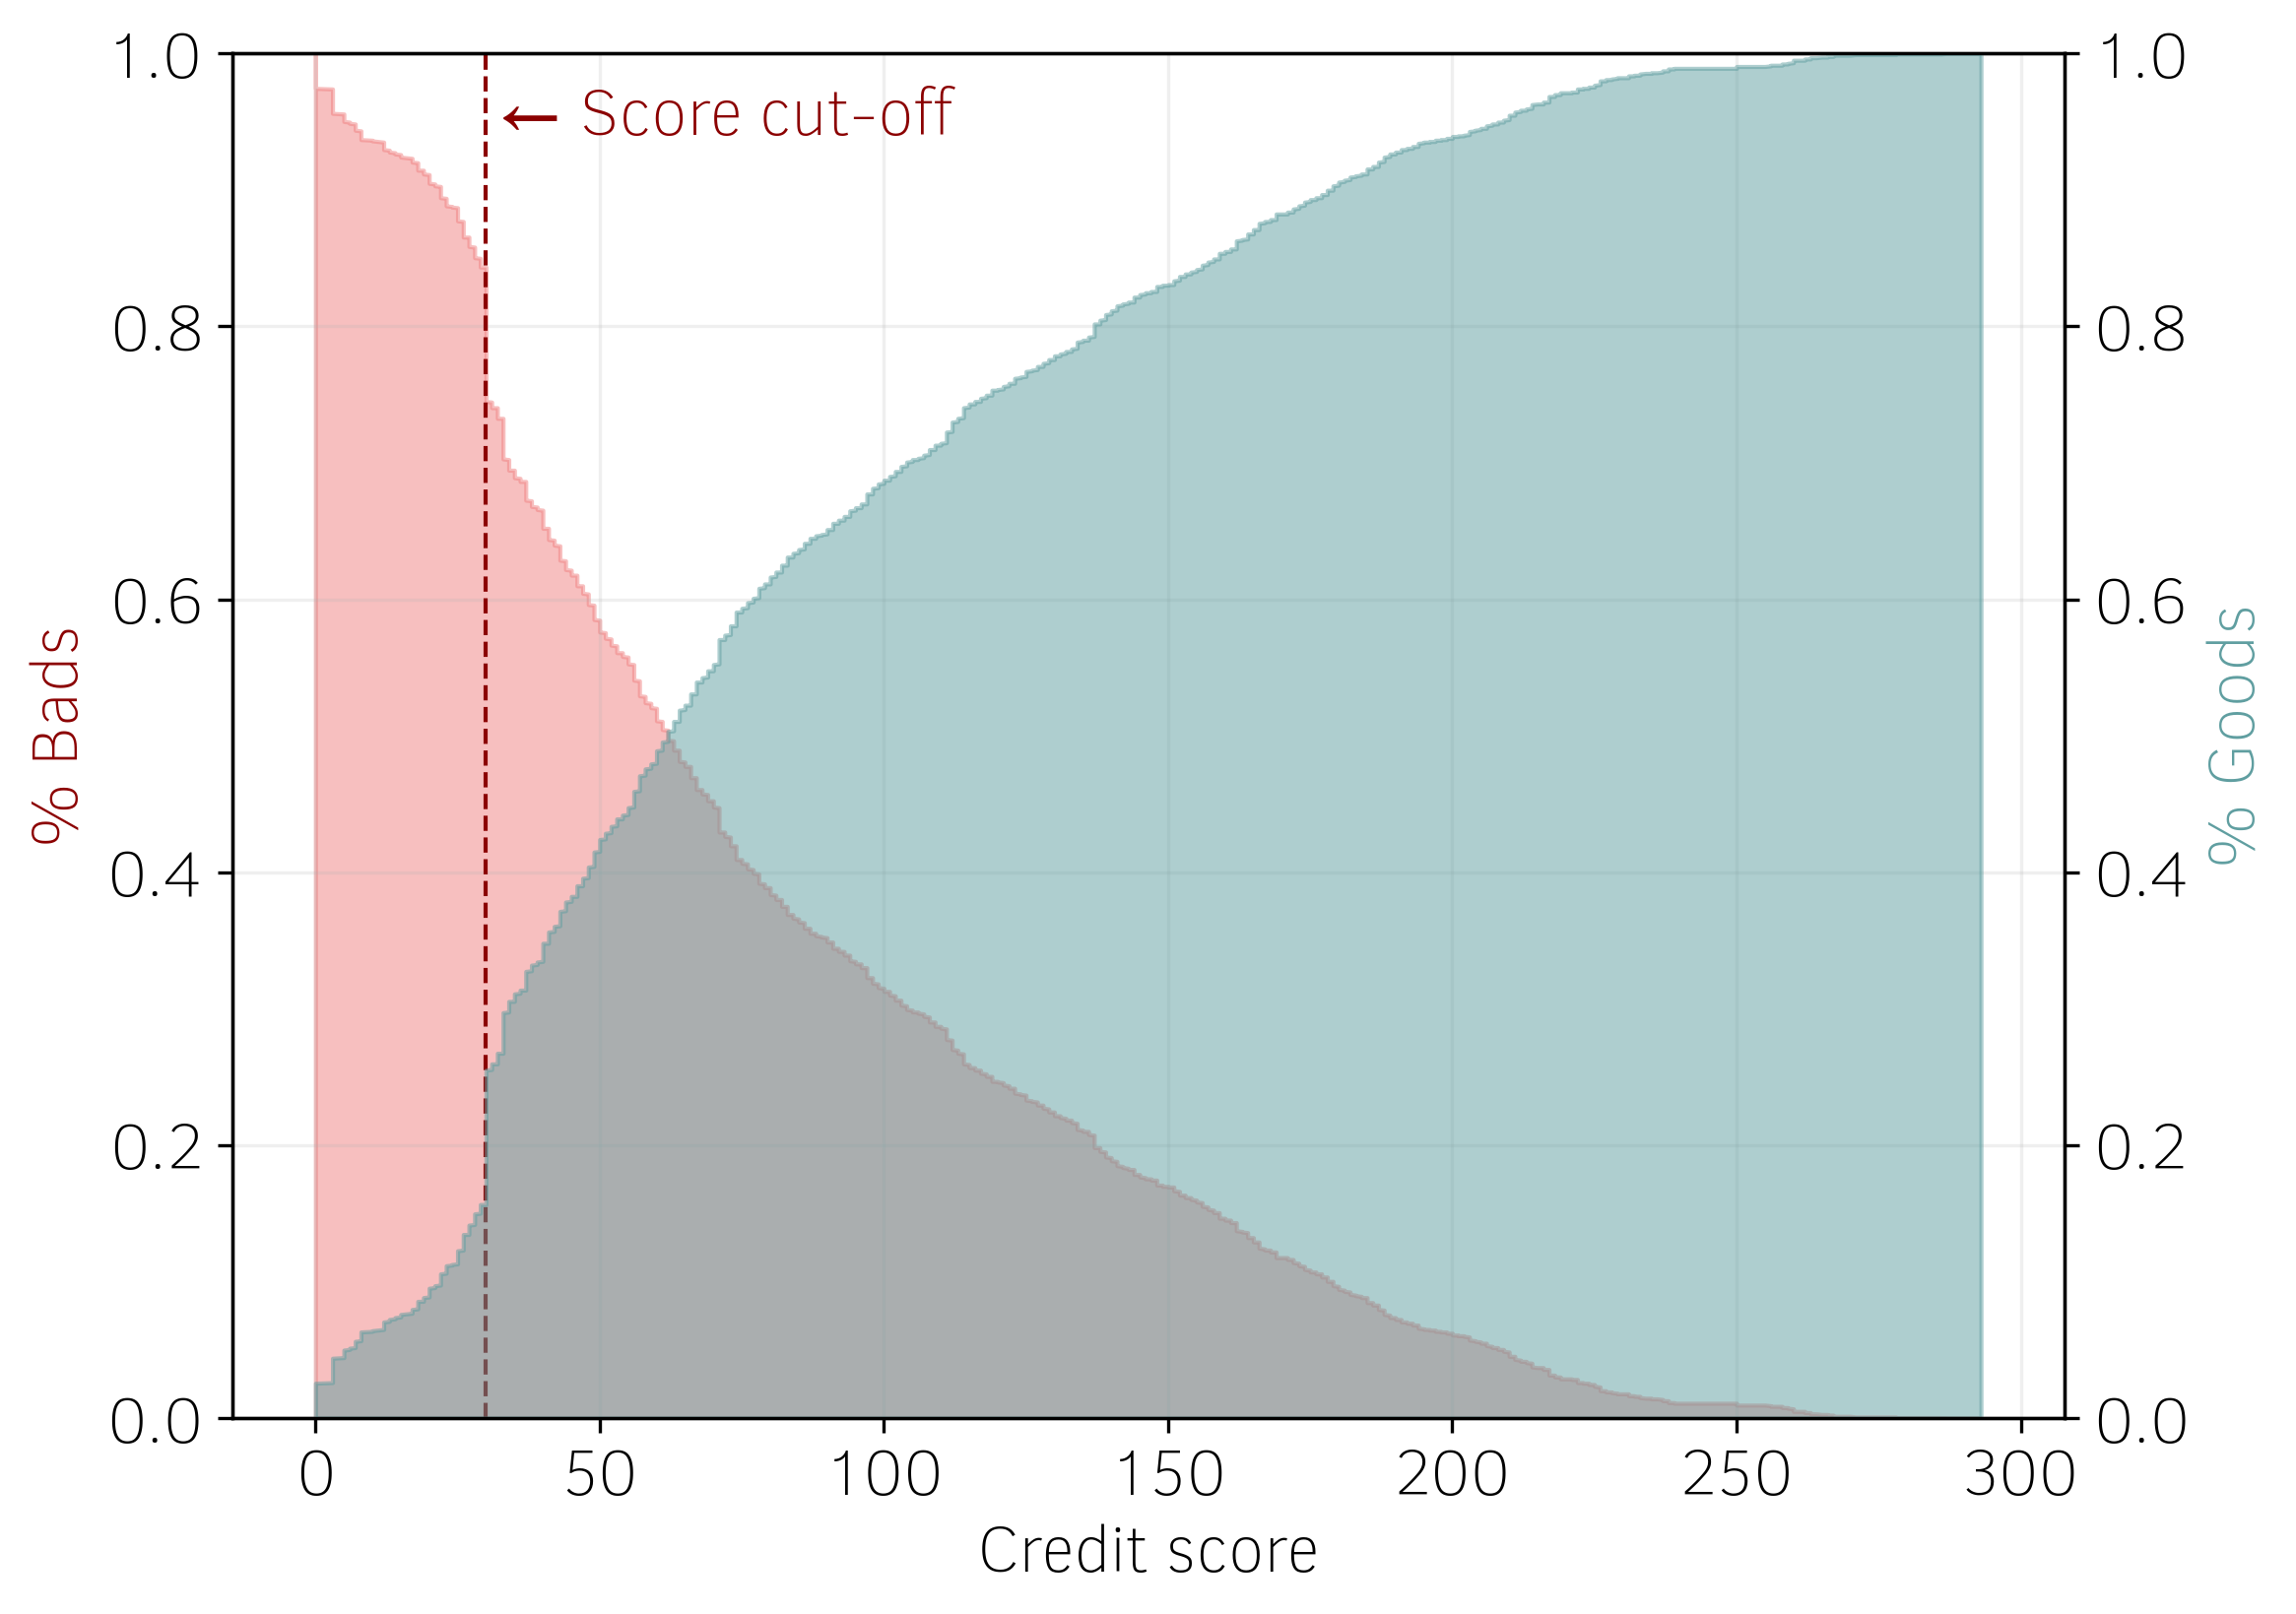

In [92]:
# add default flag
perf_eval_df = pd.concat(
    [val_scores['Score'], 
     y.loc[val_scores.index]], axis=1).reset_index(drop=True)

# evaluate accuracy
result = boosted_scorecard.calculate_accuracy(
    perf_eval_df, 
    'Score', 'RiskPerformance', 
    sort_ascending=False)

fig, ax1 = plt.subplots(dpi=300)
ax1.fill_between(
    result['threshold'], 
    result['share_defaults'],
    color='lightcoral',
    antialiased=True,
    alpha=0.5)
ax1.grid(alpha=0.2)
ax1.axvline(
    x=30, color='darkred', 
    linewidth=1, linestyle='--')
ax1.text(32, 0.94, '← Score cut-off', color='darkred')
ax1.set_xlabel('Credit score')
ax1.set_ylabel('% Bads', color='darkred')
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
ax2.fill_between(
    result['threshold'],
    1-result['share_defaults'],
    color='cadetblue',
    antialiased=True,
    alpha=0.5)
ax2.set_ylabel('% Goods', color='cadetblue')
ax2.set_ylim(0, 1)

plt.savefig('score_cut_off.png', bbox_inches='tight', dpi=600)
plt.show()

In [90]:
# test that rank ordering of score and xgb probs is aligned
test_df = pd.concat([val_scores['Score'], y.loc[val_scores.index]], axis=1)

gini_sc = roc_auc_score(test_df['RiskPerformance'], -test_df['Score'])*2-1
gini_xgb = roc_auc_score(y.loc[ix_val_full], xgb_model.predict_proba(X.loc[ix_val_full])[:,1])*2-1

print(f"Gini scorecard: {gini_sc:.2%}")
print(f"Gini XGBoost: {gini_xgb:.2%}")

Gini scorecard: 53.23%
Gini XGBoost: 53.25%


### <span style="font-family: ClearSans-Bold, sans-serif; color:#7060eb">Model-level explanations</span>

In [30]:
import shap

#### <span style="font-family: ClearSans, sans-serif; color:#7060eb">Custom importances</span>

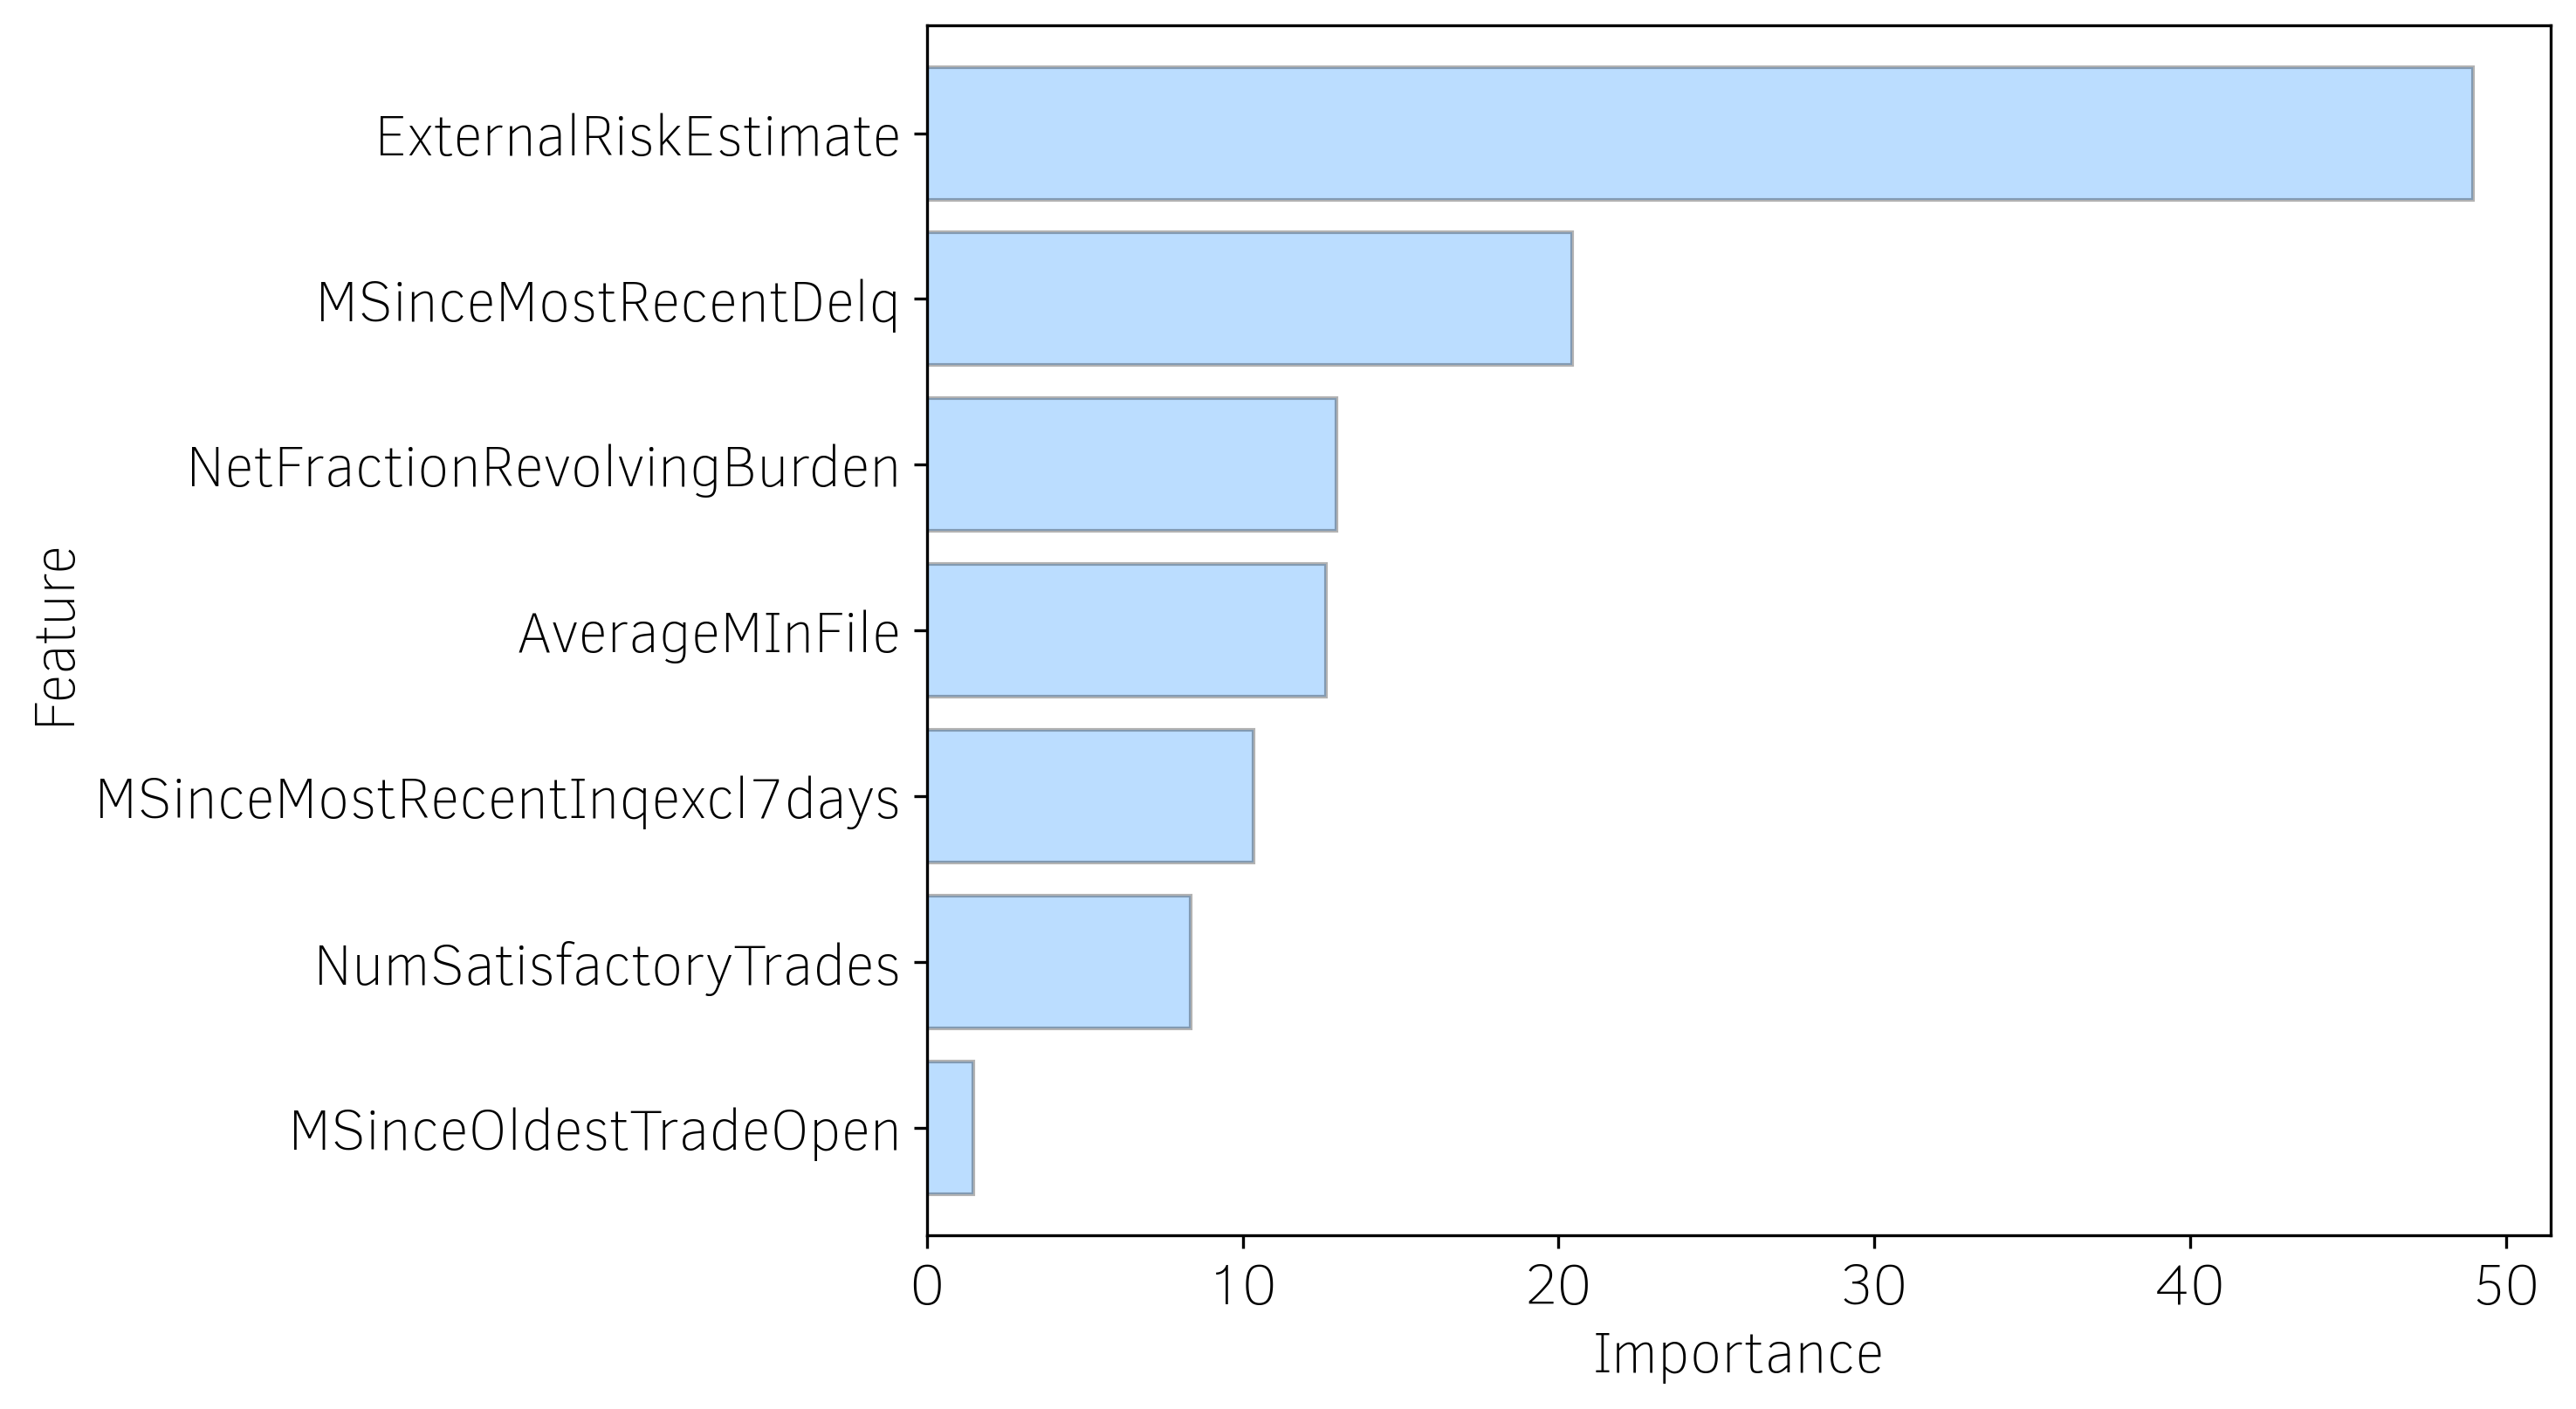

In [93]:
feats = val_scores.columns.to_list()
feats.remove('Score')

importances = {'Feature': [], 'Importance': []}

for feat in feats:
    importance = val_scores[feat].mean()
    importances['Feature'].append(feat)
    importances['Importance'].append(importance)

bstr_importances = pd.DataFrame(importances).sort_values(by='Importance', ascending=True)
# select top 7 features
bstr_importances_top = bstr_importances.sort_values(by='Importance', ascending=False)[0:7]
top_imp = bstr_importances_top.iloc[:,0].to_list()

fig = plt.figure(dpi=300)
bstr_importances[bstr_importances['Feature'].isin(top_imp)].plot(
    kind='barh', width=0.8, 
    color='dodgerblue', alpha=0.3, x='Feature', 
    legend=False, xlabel='Importance',
    edgecolor='black', ax = plt.gca())
fig.savefig('custom_importance.png', bbox_inches='tight', dpi=600)

#### <span style="font-family: ClearSans, sans-serif; color:#7060eb">SHAP importances</span>

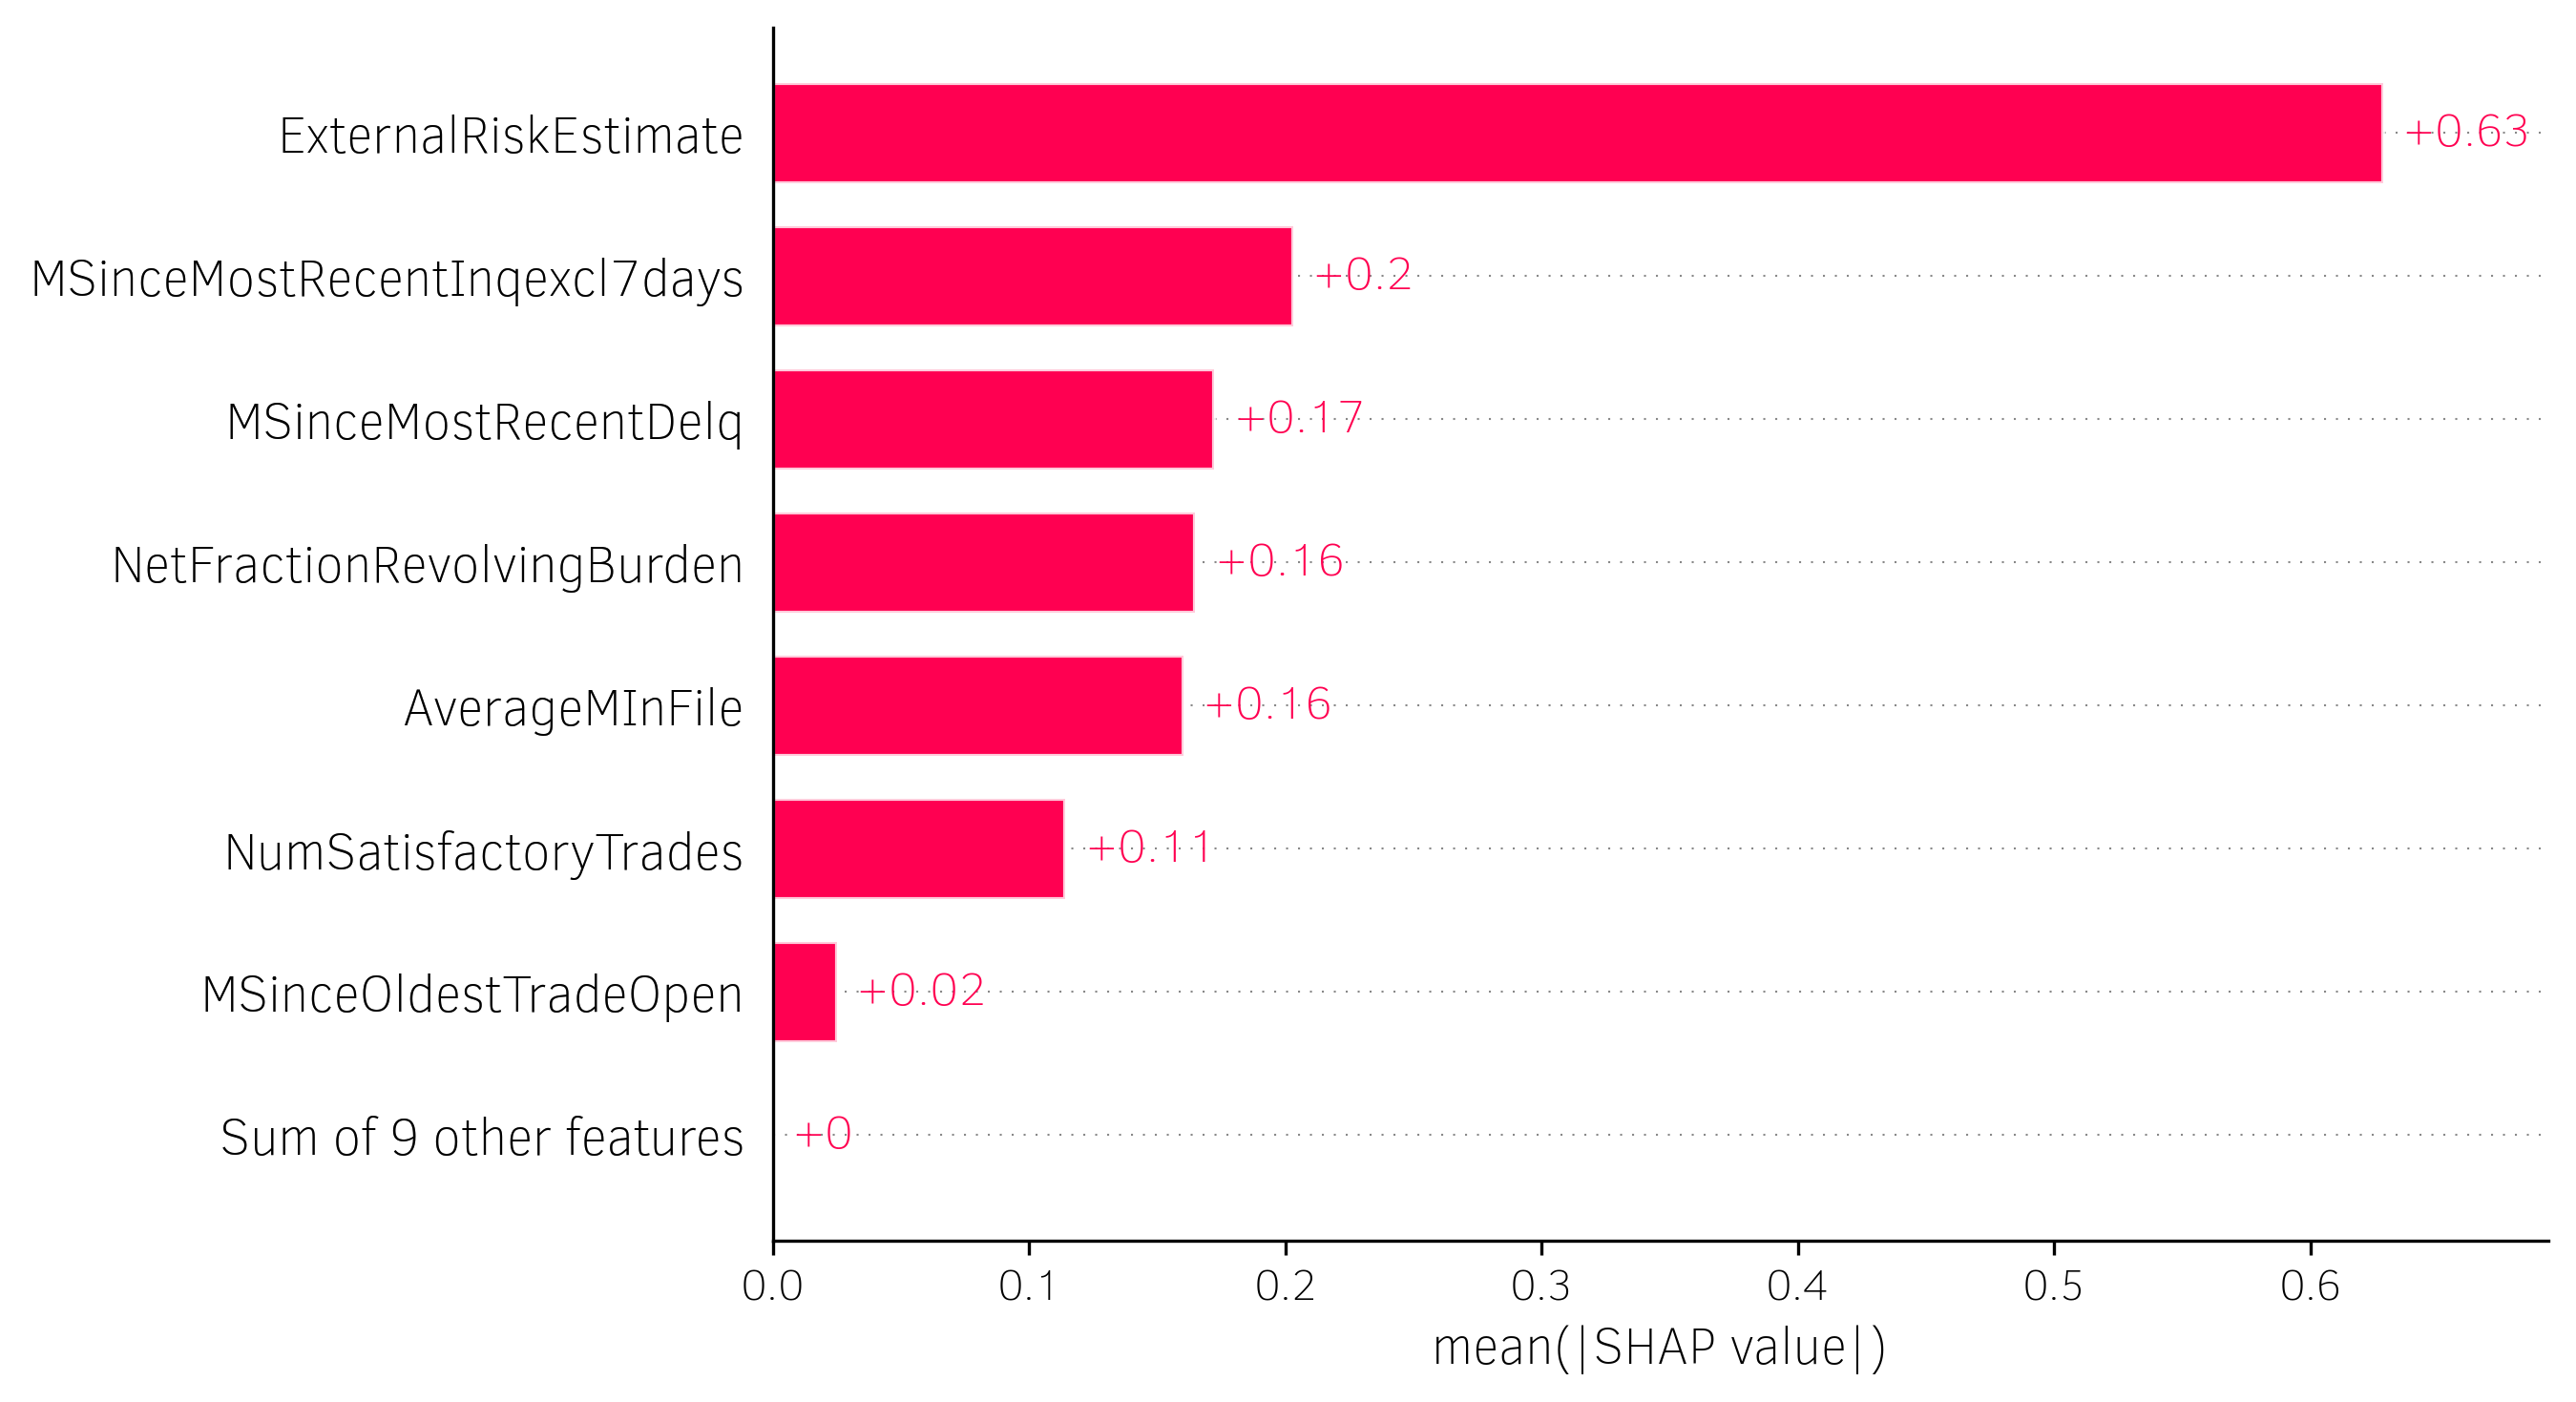

In [32]:
explainer = shap.Explainer(xgb_model, X.loc[ix_val])
shap_values = explainer(X.loc[ix_val])

fig=plt.figure(dpi=300)
shap.plots.bar(shap_values, max_display=8, show=False)
fig.savefig('shap_importance.png', bbox_inches='tight', dpi=600)